# Supervised Learning: Support Vector Machines: 

# Kernal SVMs: rbf: two hyperparamters to tune

* common to all SVM kernels
    * hyperparamter C for regularisation
    * trades off misclassification of training examples against simplicity of the decision surface
        * low C makes the decision surface smooth
            * encourage a larger margin => simpler decision function => at the cost of training accuracy
            * "soft margin"
        * high C aims at classifying all training examples correctly
            * a smaller margin will be accepted if the decision function is better at classifying all training points correctly
            * "hard margin"

* Training an SVM with Radial Basis Function kernel:
    * $k_\text{rbf}(\mathbf{x}, \mathbf{x}') = \exp(\gamma||\mathbf{x} -\mathbf{x}'||^2)$ 
    * hyperparameter = "gamma" = bandwidth = how much **influence** a single training example has
        * larger gamma is, the closer other examples must be to be affected
            * each data point will have much more local influence
        * "inverse of the radius of influence of samples selected by the model as support vectors"
        * smaller gamma => smoother boundary

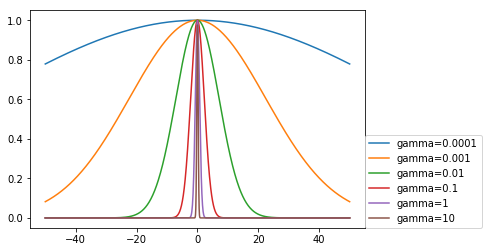

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

line = np.linspace(-50, 50, 1000)
def rbf(gamma):
    return np.exp(-gamma * line**2)

for gamma in [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]:
    plt.plot(line, rbf(gamma), label="gamma={}".format(gamma))
plt.legend(loc=(1, 0))

# low gamma:
#   ‘far’ 
#   'broad' bandwidth
#   'less complex' model
#   "wider kernel"
#   smoother decision boundary 

In [2]:
colors = [plt.cm.tab10(0), plt.cm.tab10(0), plt.cm.tab10(1), plt.cm.tab10(1)]

def make_handcrafted_dataset():
    from sklearn.datasets import make_blobs
    # a carefully hand-designed dataset lol
    X, y = make_blobs(centers=2, random_state=4, n_samples=30)
    y[np.array([7, 27])] = 0
    mask = np.ones(len(X), dtype=np.bool)
    mask[np.array([0, 1, 5, 26])] = 0
    X, y = X[mask], y[mask]
    return X, y

def plot_svm(log_C, log_gamma, ax=None):
    C = 10. ** log_C
    gamma = 10. ** log_gamma
    from sklearn.svm import SVC
    svm = SVC(kernel='rbf', C=C, gamma=gamma).fit(X, y)
    if ax is None:
        ax = plt.gca()
    predictions = svm.decision_function(X_grid)
    ax.contourf(x_grid, y_grid, predictions.reshape(x_grid.shape), alpha=.3, cmap='coolwarm') #, colors=colors)
    ax.contour(x_grid, y_grid, predictions.reshape(x_grid.shape), levels=[0])

    # plot data
    ax.scatter(X[:, 0], X[:, 1], c=y, s=70, cmap='coolwarm')
    
    # plot support vectors
    support_vectors = svm.support_
    ax.scatter(X[support_vectors, 0], X[support_vectors, 1], facecolor='none', edgecolor='k', linewidths=1, s=150)
    
    ax.set_title("C = %.4f gamma = %.2f" % (C, gamma))

In [3]:
X, y = make_handcrafted_dataset()

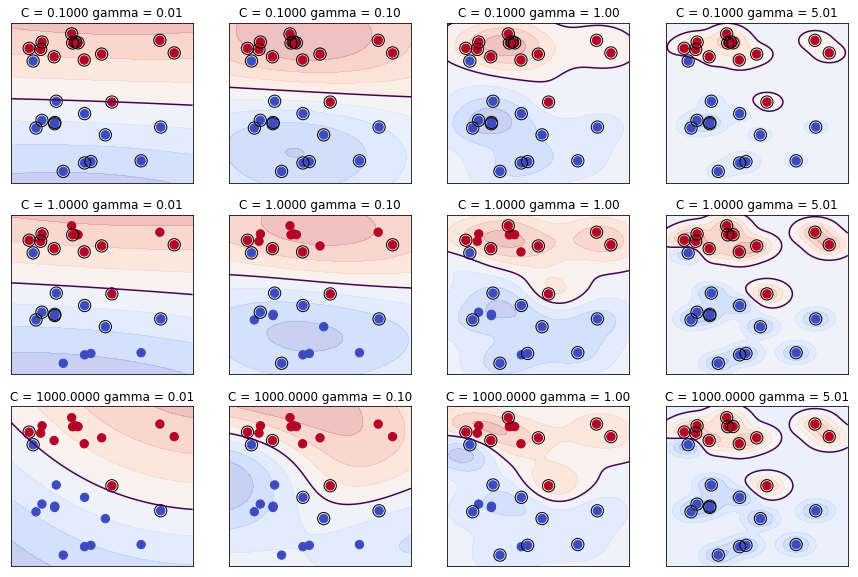

In [4]:
# create a grid for plotting decision functions...
x_lin = np.linspace(X[:, 0].min() - .5, X[:, 0].max() + .5, 1000)
y_lin = np.linspace(X[:, 1].min() - .5, X[:, 1].max() + .5, 1000)
x_grid, y_grid = np.meshgrid(x_lin, y_lin)
X_grid = np.c_[x_grid.ravel(), y_grid.ravel()]
    
fig, axes = plt.subplots(3, 4, figsize=(15, 10), subplot_kw={'xticks':(), 'yticks': ()})

for ax, C in zip(axes, [-1, 0, 3]):
    for a, gamma in zip(ax, [-2, -1, 0, .7]):
        plot_svm(log_C=C, log_gamma=gamma, ax=a)
        
        
# the vertical is C
# the horizontal is gamma
# support vectors are marked with circles

# simplest model = smallest gamma & smallest C => lots of data points = support vectors (broad kernel)

* gamma = large 
    * radius of the area of influence of the support vectors only includes the support vector itself
    * no amount of regularization with C will be able to prevent **overfitting.**

* gamma = small
    * model = constrained (cannot capture the complexity or “shape” of the data)
    * region of influence of any selected support vector would include the whole training set
    * model will behave similarly to a linear model with a set of hyperplanes that separate the centers of high density of any pair of two classes.

* Tradeoff:
    * Smooth models (lower gamma values) => more complex => by increasing the importance of classifying each point correctly (larger C values)
    

EXTRA: iris eg: https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html

### NB: example of changing parameter C with make_blobs that overlap

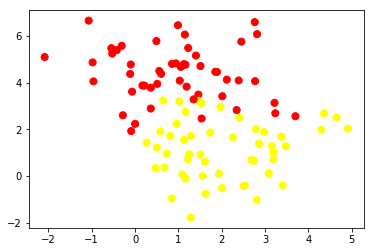

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=100, 
                  centers=2,
                  random_state=0, 
                  cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

In [6]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    import numpy as np
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

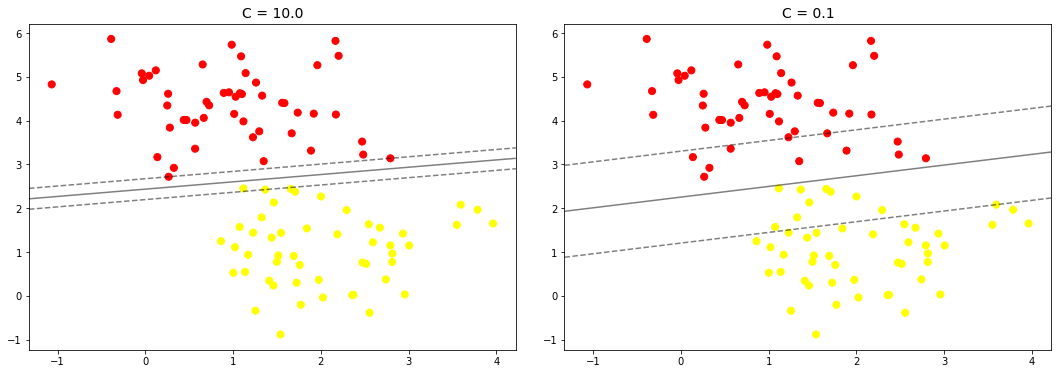

In [7]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

from sklearn.svm import SVC

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)